In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/My\ Drive/CamVid.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/CamVid.zip
replace CamVid/test/0001TP_008550.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_0090

In [ ]:
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import tensorflow as tf

from numpy import asarray

from PIL import Image
from random import random

from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

from torch.nn import Sequential, Module
from torch.nn import Conv2d, ReLU, Sigmoid, BatchNorm2d, Dropout
from torch.nn import ConvTranspose2d, MaxPool2d, MaxUnpool2d

from pytorch_model_summary import summary

from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

from segmentation_models_pytorch import utils

In [ ]:
x_train_dir = '/content/CamVid/train'
y_train_dir = '/content/CamVid/train_labels'

x_val_dir = '/content/CamVid/val'
y_val_dir = '/content/CamVid/val_labels'

x_test_dir = '/content/CamVid/test'
y_test_dir = '/content/CamVid/test_labels'

# 1. CNN model (Baseline)

### 1.1 Define custom dataset

In [ ]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            
            return image, mask
        
        else:
            # read data
            image = Image.open(self.images_paths[i])
            
            # apply transforms
            image = self.transforms(image)
            
            return image
        
    def __len__(self):
        return len(self.image_names)

### 1.2 Data Exploration

In [ ]:
# Resizing images to 224 x 224

train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [ ]:
dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')

image, gt_mask = dataset[0]

In [ ]:
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

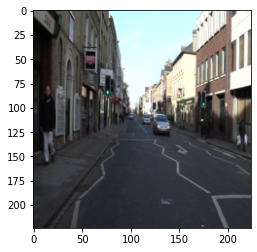

In [ ]:
plt.imshow(np.transpose(image, (1, 2, 0)))

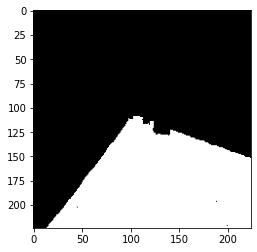

In [ ]:
# true mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [ ]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=2
)

In [ ]:
for batch_x, batch_y in train_loader:
    break

In [ ]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 1.3 Define Model Architecture

In [ ]:
# define model architecture

# Input

# Encoder
## Conv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxPool(size=2)
## Conv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxPool(size=2)

# Decoder
## MaxUnpool(size=2)
## TransposeConv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')
## MaxUnpool(size=2)
## TransposeConv(num_filters=64, filter_size=3, stride=2, padding=1, activation='relu')

# Output
## Conv(num_filters=1, filter_size=3, stride=1, padding=1, activation='sigmoid')


class EncoderDecoder(Module):
    def __init__(self):
        super().__init__()

        # define encoder
        self.encoder_block1 = Sequential(
            Conv2d(3, 64, 3, stride=2, padding=1), 
            ReLU()
        )

        self.pool1 = MaxPool2d(2, return_indices=True)

        self.encoder_block2 = Sequential(
            Conv2d(64, 128, 3, stride=2, padding=1), 
            ReLU()
        )

        self.pool2 = MaxPool2d(2, return_indices=True)

        # define decoder        
        self.unpool2 = MaxUnpool2d(2)

        self.decoder_upsample2 = ConvTranspose2d(128, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity2 = ReLU()

        self.unpool1 = MaxUnpool2d(2)

        self.decoder_upsample1 = ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.decoder_non_linearity1 = ReLU()

        # define output
        self.output_layer = Sequential( 
            Conv2d(64, 1, 3, stride=1, padding=1),
            Sigmoid()
        )

    def forward(self, x):
        # get input shape for encoder block 1
        size_input_encoder_block1 = x.shape
        x = self.encoder_block1(x)
        # get pooling indices of pool 1
        x, indices_pool1 = self.pool1(x)

        # get input shape for encoder block 2
        size_input_encoder_block2 = x.shape
        x = self.encoder_block2(x)
        # get pooling indices of pool 2
        x, indices_pool2 = self.pool2(x)

        # use pooling indices of pool 2
        x = self.unpool2(x, indices_pool2)
        # use input shape of encoder block 2
        x = self.decoder_upsample2(x, output_size=size_input_encoder_block2)
        x = self.decoder_non_linearity2(x)

        # use pooling indices of pool 1
        x = self.unpool1(x, indices_pool1)
        # use input shape of encoder block 1
        x = self.decoder_upsample1(x, output_size=size_input_encoder_block1)
        x = self.decoder_non_linearity1(x)

        x = self.output_layer(x)
        return x

In [ ]:
# define model
model = EncoderDecoder()

In [ ]:
# print model
model

EncoderDecoder(
  (encoder_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity2): ReLU()
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (decoder_upsample1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (decoder_non_linearity1): ReLU()
  (output_layer): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# print model summary
print(summary(model, batch_x[1].unsqueeze(dim=0)))

---------------------------------------------------------------------------------------------
         Layer (type)                           Output Shape         Param #     Tr. Param #
             Conv2d-1                      [1, 64, 112, 112]           1,792           1,792
               ReLU-2                      [1, 64, 112, 112]               0               0
          MaxPool2d-3       [1, 64, 56, 56], [1, 64, 56, 56]               0               0
             Conv2d-4                       [1, 128, 28, 28]          73,856          73,856
               ReLU-5                       [1, 128, 28, 28]               0               0
          MaxPool2d-6     [1, 128, 14, 14], [1, 128, 14, 14]               0               0
        MaxUnpool2d-7                       [1, 128, 28, 28]               0               0
    ConvTranspose2d-8                        [1, 64, 56, 56]          73,792          73,792
               ReLU-9                        [1, 64, 56, 56]         

In [ ]:
# check model on one image
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

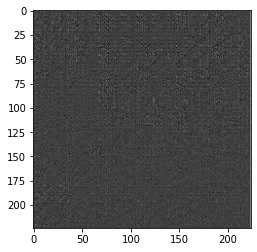

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 1.4 Train the model

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs, batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

Training loss for epoch 1 is 0.6220250829406406 
Training loss for epoch 2 is 0.5438981004383253 
Training loss for epoch 3 is 0.4688043710978135 
Training loss for epoch 4 is 0.3922864509665448 
Training loss for epoch 5 is 0.35063339186751324 


### 1.5 Testing the model on a single validation image

In [ ]:
# get sample data
image = Image.open('/content/CamVid/val/0016E5_07959.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07959.png')

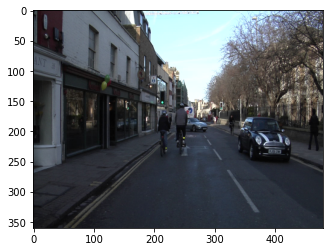

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data pre-processing
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])
        
image = transform(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()

output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

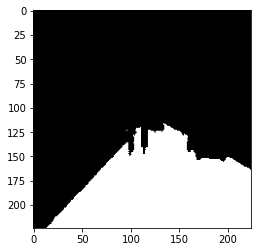

In [ ]:
# true mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

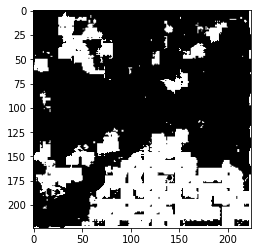

In [ ]:
# predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

0.5449377228797354

### 1.6 Mean IOU Score for validation set

In [ ]:
valid_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir, 
    transforms=valid_transforms,
    training_type='valid'
)

In [ ]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [ ]:
# Obtaining true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [ ]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

0.66229904

# 2. DeepLabv3

### 2.1 Define custom dataset

In [ ]:
# define custom dataset class
class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)
            
            return image, mask
        
        else:
            # read data
            image = Image.open(self.images_paths[i])
            
            # apply transforms
            image = self.transforms(image)
            
            return image
        
    def __len__(self):
        return len(self.image_names)

### 2.2 Data Exploration

In [ ]:
# Resizing images to 224 x 224

train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])

In [ ]:
dataset = CamVidDataset(x_train_dir, y_train_dir, transforms=train_transforms, training_type='train')

image, gt_mask = dataset[0]

In [ ]:
image.shape, gt_mask.shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

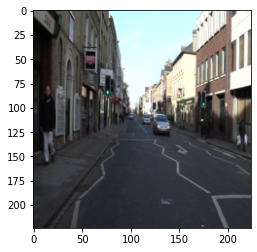

In [ ]:
plt.imshow(np.transpose(image, (1, 2, 0)))

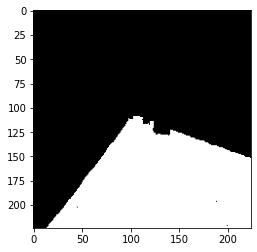

In [ ]:
# true mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [ ]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=2
)

In [ ]:
for batch_x, batch_y in train_loader:
    break

In [ ]:
batch_x.shape, batch_y.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 224, 224]))

### 2.3 Define model architecture

In [ ]:
model = deeplabv3_resnet101(pretrained=True)

In [ ]:
for parameters in model.parameters():
    parameters.requires_grad = False

In [ ]:
model.classifier = DeepLabHead(in_channels=2048, num_classes=1)

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224))['out'].detach().numpy()

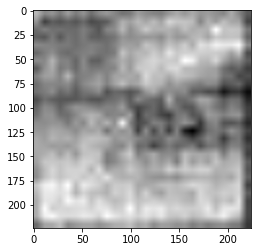

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 2.4 Train the model

In [ ]:
# transfer model to GPU
model = model.to("cuda")

In [ ]:
# define optimization and loss function
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

In [ ]:
# set model to train
model.train()

# train model
for epoch in range(5):

    # initialize variables
    epoch_loss = cnt = 0

    # loop through the data
    for batch_x, batch_y in train_loader:
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()
        batch_y = batch_y.to("cuda").float()

        # clear gradients
        optimizer.zero_grad()

        # pass images to model
        outputs = model(batch_x)

        # get loss
        loss = criterion(outputs['out'], batch_y)

        # do a backward pass
        loss.backward()

        # update gradients
        optimizer.step()

        # sum loss and get count
        epoch_loss += loss.item()
        cnt += 1

    # take average loss for all batches
    epoch_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {} ".format(epoch + 1, epoch_loss))

RuntimeError: ignored

### 2.5 Testing model on an image from validation set

In [ ]:
# get sample data     
image = Image.open('/content/CamVid/val/0016E5_07959.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07959.png')

In [ ]:
plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data augmentation
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])
        
image = transform(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda"))['out'].cpu().detach().numpy()

In [ ]:
# true mask
plt.imshow(gt_mask.squeeze(), cmap='gray')

In [ ]:
# predicted mask
plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

### 2.6 Mean IOU Score for validation set

In [ ]:
valid_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir, 
    transforms=valid_transforms,
    training_type='valid'
)

In [ ]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda'))['out'].cpu().detach().numpy()

        #mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [ ]:
# Obtaining true validation masks

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  img = img.resize((224, 224))
  a = asarray(img)
  b = (a == 3)
  c = 1*b
  true_masks.append(c)

In [ ]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

# 3. U-Net

### 3.1 Define custom dataset

In [ ]:
# define custom dataset class (Data augmentation and normalization of images added)

class CamVidDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transforms=None, preprocessing=False, training_type=None):
        # get all image names
        self.image_names = os.listdir(images_dir)

        # set training type, transforms
        self.training_type = training_type
        self.transforms = transforms
        self.preprocessing=preprocessing

        # get image and target paths
        self.images_paths = []
        self.masks_paths = []
        for image_name in self.image_names:
            self.images_paths.append(os.path.join(images_dir, image_name))
            if self.training_type=="train" or self.training_type=="val":
                self.masks_paths.append(os.path.join(masks_dir, image_name.split('.')[0] + '.png'))
    
    def __getitem__(self, i):
        
        if self.training_type=="train" or self.training_type=="val":
            # read data
            image = Image.open(self.images_paths[i])
            mask = Image.open(self.masks_paths[i])

            # preprocess mask
            mask = np.array(mask)
            mask = (mask == 3)
            mask = Image.fromarray(mask)

            # data augmentation
            ## random horizontal flip
            if random() < 0.5:
                image, mask = F.hflip(image), F.hflip(mask)

            ## apply transforms
            image = self.transforms(image)
            mask = self.transforms(mask)

            ## apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],        
                        std=[0.229, 0.224, 0.225])])(image)
            
            return image, mask
        
        else:
            # read data
            image = Image.open(self.images_paths[i])
            
            # apply transforms
            image = self.transforms(image)

            # apply preprocessing
            if self.preprocessing:
                image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)  
            
            return image
        
    def __len__(self):
        return len(self.image_names)

In [ ]:
# create transform
train_transforms = Compose([
    Resize((224, 224)),
    ToTensor()
])
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=2
)

### 3.2 Data Exploration

In [ ]:
for batch_x, batch_y in train_loader:
    break

In [ ]:
batch_x.shape, batch_y.shape

In [ ]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

In [ ]:
# True Mask

plt.imshow(batch_y[0].squeeze(), cmap='gray')

In [ ]:
# create instance of custom dataset
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    transforms=train_transforms,
    preprocessing=True,
    training_type='train'
)
# create dataloader
train_loader = DataLoader(
    train_dataset, 
    batch_size=16,
    num_workers=2
)

### 3.3 Define model architecture

In [ ]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name='resnet18', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)

In [ ]:
# print model
model

In [ ]:
# check for one iteration of loop
for batch_x, batch_y in train_loader:
    break

In [ ]:
# check model on one image
model.eval()
output = model(batch_x[1].view(1, 3, 224, 224)).detach().numpy()

In [ ]:
# print output
plt.imshow(output.squeeze(), cmap='gray')

### 3.4 Train the model

In [ ]:
# define loss function
criterion = smp.utils.losses.BCELoss()

# define optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=1e-3)

# define evaluation metric
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)
]

In [ ]:
# define training epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

In [ ]:
# Saving best model and Decrease in LR after 10th epoch added for U-Net model
max_score = 0

for i in range(0, 20):
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    # decreasing learning rate after 10th epoch
    if i+1 == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease learning rate to 1e-5')

In [ ]:
# load best saved checkpoint
model = torch.load('./best_model.pth')

### 3.5 Testing model on an image from validation set

In [ ]:
# get sample data
image = Image.open('/content/CamVid/val/0016E5_07959.png')
gt_mask = Image.open('/content/CamVid/val_labels/0016E5_07959.png')

In [ ]:
# Original image

plt.imshow(image)

In [ ]:
# preprocess mask
gt_mask = np.array(gt_mask)
gt_mask = (gt_mask == 3)
gt_mask = Image.fromarray(gt_mask)

# apply data pre-processing
transform = Compose([
            Resize((224, 224)),
            ToTensor()
            ])
        
image = transform(image)

image = Compose([Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])(image)

gt_mask = transform(gt_mask)

In [ ]:
model.eval()
output = model(image.view(1, 3, 224, 224).to("cuda")).cpu().detach().numpy()

In [ ]:
# true Mask

plt.imshow(gt_mask.squeeze(), cmap='gray')

In [ ]:
# predicted Mask

plt.imshow((output.squeeze() > 0.5).astype(int), cmap='gray')

In [ ]:
# convert predicted mask to flattened numpy array
mask = (output.squeeze() > 0.5).astype(int)
pred = mask.ravel().copy()

# convert ground truth mask to flattened numpy array
gt_mask = gt_mask.cpu().detach().numpy()
target = gt_mask.ravel().copy().astype(int)

# get class indices for Lane
pred_inds = pred == 1
target_inds = target == 1

# calculate intersection
intersection = pred_inds[target_inds].sum()

# calculate union
union = pred_inds.sum() + target_inds.sum() - intersection

# get IoU score
iou = (float(intersection) / float(max(union, 1)))
iou

### 3.6 Mean IOU Score for validation set

In [ ]:
valid_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

valid_dataset = CamVidDataset(
    x_val_dir, 
    transforms=valid_transforms,
    preprocessing=True,
    training_type='valid'
)

In [ ]:
# Obtaining all predicted validation masks
valid_masks = []
model.eval()
with torch.no_grad():
    for valid_image in valid_dataset:
        mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()

        #mask = model(valid_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        valid_masks.append(mask)

valid_masks = (np.concatenate((valid_masks), axis=0) > 0.5).astype(int)

In [ ]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()])

image_names = os.listdir(y_val_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_val_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

In [ ]:
T = []

for i in range(len(valid_dataset)):
  p = valid_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)

# 4. Inference on test dataset (applying Model 3 - UNet)

### 4.1 Obtaining prediction masks for test set

In [ ]:
test_transforms = Compose([
    Resize((224, 224)), 
    ToTensor()
])

test_dataset = CamVidDataset(
    x_test_dir, 
    transforms=test_transforms,
    preprocessing=True,
    training_type='test'
)

In [ ]:
# run model for all images in test dataset
test_masks = []
model.eval()
with torch.no_grad():
    for test_image in test_dataset:
        mask = model(test_image.unsqueeze(0).to('cuda')).cpu().detach().numpy()
        test_masks.append(mask)

test_masks = (np.concatenate((test_masks), axis=0) > 0.5).astype(int)

In [ ]:
# show original image
test_image = test_dataset[230]
plt.imshow(np.transpose(test_image, (1, 2, 0)))

In [ ]:
# show prediction
plt.imshow((test_masks[230]).squeeze(), cmap='gray')

### 4.2 True mask for test set

In [ ]:
# Obtaining true validation masks

transform = Compose([Resize((224, 224)),ToTensor()])

image_names = os.listdir(y_test_dir)
true_masks = []

for image_name in image_names:
  mask_path = os.path.join(y_test_dir, image_name)
  img = Image.open(mask_path)
  gt_mask = np.array(img)
  gt_mask = (gt_mask == 3)
  gt_mask = Image.fromarray(gt_mask)
  gt_mask = transform(gt_mask)
  true_masks.append(gt_mask)

### 4.3 Mean IOU score for test set

In [ ]:
T = []

for i in range(len(test_dataset)):
  p = test_masks[i].flatten()
  q = true_masks[i].flatten()
  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(p, q)
  T.append(m.result().numpy())

np.mean(T)